In [3]:
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from random import shuffle

import os
import glob
from tqdm import tqdm

from util import load_positive_samples, load_negative_samples

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

In [2]:
positive_samples = load_positive_samples()
negative_samples = load_negative_samples()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.80it/s]


In [3]:
def plot_img(samples, select_num=12):   
    num_samples = len(samples)
    selected_index = np.random.choice(num_samples, select_num, replace=True)
    
    count = 0
    for index in selected_index:
        count += 1     
        plt_idx = count
        plt.subplot(1, select_num, plt_idx)
        plt.imshow(samples[index])
        plt.axis('off')
        
    plt.show()

6126


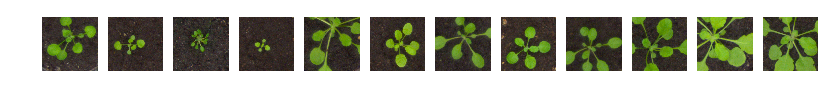

In [16]:
print(len(positive_samples))
plot_img(positive_samples)

11916


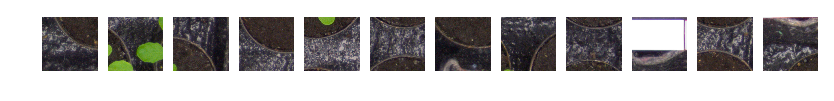

In [28]:
print(len(negative_samples))
plot_img(negative_samples)

In [19]:
from sklearn.model_selection import train_test_split

labels = []
fds = []
for sample in positive_samples:
    sample = np.transpose(sample)
    fds.append(sample[:3,:,:])
    labels.append([1, 0])

shuffle(negative_samples)
for sample in negative_samples:
    sample = np.transpose(sample)
    fds.append(sample[:3,:,:])
    labels.append([0, 1])

X_train, X_test, y_train, y_test = train_test_split(
    fds, labels, test_size=0.2, random_state=0)

## Training

In [24]:
from squeezenet import SqueezeNet, ConvNet

# here you can switch between different CNN model
model, callback_list = ConvNet(nb_classes=2)
hist = model.fit(np.array(X_train), np.array(y_train), batch_size=32, epochs=2, verbose=1, 
                callbacks=callback_list, validation_split=0.2, validation_data=None, 
                shuffle=True, initial_epoch=0)

conv model summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 96, 112, 112)      14208     
_________________________________________________________________
conv2 (Conv2D)               (None, 96, 56, 56)        230496    
_________________________________________________________________
conv3 (Conv2D)               (None, 128, 28, 28)       110720    
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 128, 13, 13)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 13, 13)       0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 

## Evaluate

In [9]:
model.evaluate(np.array(X_test), np.array(y_test), batch_size=32, verbose=1, sample_weight=None)

3609/3609 [==============================] - 21s    


[0.012466967793228763, 0.9972291493488501]

## Testing

In [1]:
from squeezenet import SqueezeNet
model, callback_list = SqueezeNet(nb_classes=2, is_testing=True)

Using TensorFlow backend.


## Object Detection

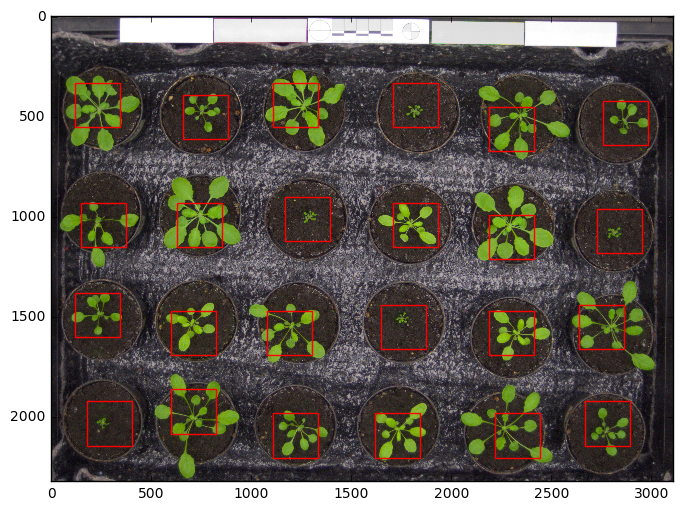

In [7]:
from util import nms
from util import sliding_window

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x[0]) / np.sum(np.exp(x))

min_window_size = (224, 224)
step_size = (30, 30)
confidence_threshold = 0.70
threshold = 0.1

detections = []

current_path = os.getcwd()
img_path = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2013-Canon', 'ara2013_tray22_rgb.png')
im = imread(img_path)

candidate_imgs = []
coordinates = []
for (x, y, im_window) in sliding_window(im, min_window_size, step_size):
        if im_window.shape[0] != min_window_size[0] or im_window.shape[1] != min_window_size[1]:
            continue
        candidate_imgs.append(np.transpose(im_window))
        coordinates.append([x, y])

candidate_imgs = np.array(candidate_imgs)
pred = model.predict(candidate_imgs)

for i, score in enumerate(pred):
    confidence = softmax(score)
    if confidence > confidence_threshold:
        detections.append((coordinates[i][0], coordinates[i][1], confidence,
            int(min_window_size[0]),
            int(min_window_size[1])))

# Display the results before performing NMS
clone = im.copy()

# Perform Non Maxima Suppression
left_detections = nms(detections, threshold)

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(clone)

# Display the results after performing NMS
for (x_tl, y_tl, _, w, h) in left_detections:
    # Draw the detections
    rect = patches.Rectangle((x_tl, y_tl), w, h, linewidth=1,edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
plt.show()